In [1]:
import numpy as np
import pandas as pd
import random
import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
np.random.seed(37)
random.seed(37)

class CdfCurve:
    def __init__(self, c, n_samples=10_000):
        self.__c = CdfCurve.to_cdf(CdfCurve.generate_samples(c, n_samples))
        
    def get_sample(self, n_samples=10_000):
        return CdfCurve.generate_samples(self.__c, n_samples)
    
    def sample_in(self, n_samples=10_000, lhs=0.0, rhs=1.0):
        c = list(self.__c.values)
        v = list(self.__c.index)
        
        samples = []
        
        while len(samples) < n_samples:
            while True:
                p = np.random.random(size=1)
                if lhs < p <= rhs:
                    index = bisect.bisect_left(c, p)
                    samples.append(v[index])
                    break
                    
        return pd.Series(samples)
    
    def get_cdf(self):
        return self.__c
    
    def get_ppf(self, p):
        return CdfCurve.ppf(self.__c.values, self.__c.index, p)
    
    @staticmethod
    def ppf(c, v, p):
        index = bisect.bisect_left(c, p)
        if index >= len(v):
            index -= 1
            
        return v[index]
    
    @staticmethod
    def generate_samples(c, n_samples=10_000):
        c, v = c.values, c.index
        s = pd.Series([CdfCurve.ppf(c, v, p) for p in np.random.random(n_samples)])
        return s
    
    @staticmethod
    def to_cdf(s):
        return (s.value_counts().sort_index() / len(s)).cumsum()
        
class GaussianMM:
    def __init__(self, gaussians, n_samples=10_000):
        self.__gaussians = gaussians
        
        self.__samples = {i: pd.Series(g.rvs(size=n_samples)) for i, g in enumerate(gaussians)}
        self.__samples['all'] = pd.concat([s for s in self.__samples.values()]).reset_index(drop=True)
        
        self.__cdfs = {i: CdfCurve.to_cdf(s) for i, s in self.__samples.items()}
        
    def get_sample(self, i='all'):
        return self.__samples[i]
    
    def get_cdf(self, i='all'):
        return self.__cdfs[i]
    
    def plot_kde(self, ax):
        for k, s in self.__samples.items():
            _ = s.plot(kind='kde', ax=ax, label=f'{k}')
            
    def plot_cdf(self, ax):
        for k, c in self.__cdfs.items():
            _ = c.plot(kind='line', ax=ax, label=f'{k}')

def plot_gmm_kde_cdf(gmm):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    gmm.plot_kde(ax[0])
    gmm.plot_cdf(ax[1])

    _ = ax[0].legend()
    _ = ax[1].legend()

    plt.tight_layout()

def plot_gmm_cdf(gmm, cdf):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    _ = gmm.get_sample().plot(kind='kde', ax=ax[0], label='from_gmm')
    _ = cdf.get_sample().plot(kind='kde', ax=ax[0], label='from_cdf')

    _ = gmm.get_cdf().plot(kind='line', ax=ax[1], label='from_gmm')
    _ = cdf.get_cdf().plot(kind='line', ax=ax[1], label='from_cdf')

    _ = ax[0].legend()
    _ = ax[1].legend()

    plt.tight_layout()

In [2]:
gmm1 = GaussianMM([norm(loc=10, scale=1), norm(loc=3.7, scale=2)])
gmm2 = GaussianMM([norm(loc=10, scale=1), norm(loc=14, scale=2), norm(loc=3.5, scale=1.5)])
gmm3 = GaussianMM([norm(loc=9, scale=1), norm(loc=16, scale=2), norm(loc=3.4, scale=1.5)])

cdf1 = CdfCurve(gmm1.get_cdf('all'))
cdf2 = CdfCurve(gmm2.get_cdf('all'))
cdf3 = CdfCurve(gmm3.get_cdf('all'))

<AxesSubplot:>

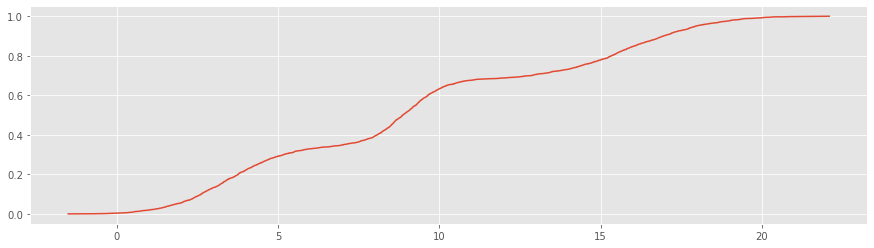

In [3]:
CdfCurve(CdfCurve.to_cdf(cdf3.sample_in(n_samples=10_000, lhs=0.0, rhs=1.0))).get_cdf().plot(figsize=(15, 4))

In [4]:
s1 = cdf1.sample_in(n_samples=10_000, lhs=0.2, rhs=1.0)
s2 = cdf2.sample_in(n_samples=10_000, lhs=0.2, rhs=1.0)
s3 = cdf3.sample_in(n_samples=10_000, lhs=0.0, rhs=0.2)

s = pd.concat([s2, s3])
c = (s.value_counts().sort_index() / s.value_counts().sum()).cumsum()

<AxesSubplot:>

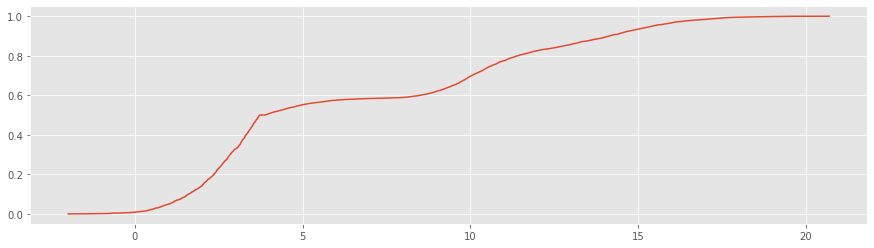

In [5]:
c.plot(kind='line', figsize=(15, 4))

<AxesSubplot:ylabel='Density'>

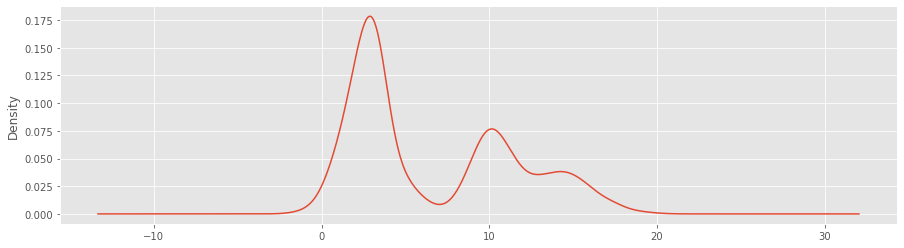

In [6]:
s.plot(kind='kde', figsize=(15, 4))